## 🚀 Informe para Optimización de Rentabilidad de Alto Volumen

### Introducción: ¿Dónde está el dinero?
Este análisis se enfoca en la **rentabilidad de los productos de mayor impacto financiero (Alto Volumen)** para identificar oportunidades de maximización de ganancias y mitigar pérdidas críticas. Se utilizó **Python y Faker** para generar un conjunto de datos sintéticos que imitan la estructura de datos transaccionales de venta real.

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from faker import Faker
import datetime

# Configuración visual
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

# Inicializamos Faker
fake = Faker('es_ES') 

# Definimos los umbrales de tu consultoría
UMBRAL_CANTIDAD = 100
UMBRAL_MARGEN = 15.0 

# --- GENERACIÓN DE DATOS FICTICIOS CON CATEGORÍAS MODIFICADAS ---
num_registros = 500 
# LISTA DE CATEGORÍAS ACTUALIZADA
categorias = ['ACCESORIOS DE VIAJE', 'ROPA DEPORTIVA TÉCNICA', 'EQUIPAMIENTO OUTDOOR'] 
# ----------------------------------------
datos = []

for i in range(num_registros):
    margen_base = random.uniform(0.1, 0.4) 
    
    cantidad = random.randint(UMBRAL_CANTIDAD, 3000)
    precio_venta_promedio = round(random.uniform(20, 150), 2)
    dolares_total = round(cantidad * precio_venta_promedio * random.uniform(0.95, 1.05), 2)
    
    costo_total = round(dolares_total * (1 - margen_base), 2) 

    sku_modelo = f"{random.randint(100, 999)}{random.choice('ABCD')}"
    
    dato = {
        'Cantidad': cantidad,
        'Dolares': dolares_total,
        'Costo': costo_total,
        'Categoria': random.choice(categorias),
        'SKU': sku_modelo,
        'Precio_Venta': round(dolares_total / cantidad, 2)
    }
    datos.append(dato)

df = pd.DataFrame(datos)
df_alto_volumen = df.copy() 

print(f"✅ Dataset Sintético Generado con {df_alto_volumen.shape[0]} registros listos para el análisis.")
display(df_alto_volumen.head())

✅ Dataset Sintético Generado con 500 registros listos para el análisis.


,Cantidad,Dolares,Costo,Categoria,SKU,Precio_Venta
0,2547,290441.05,207984.40,ACCESORIOS DE VIAJE,277D,114.03
1,211,8046.59,7154.29,ACCESORIOS DE VIAJE,699C,38.14
2,625,33365.74,25019.00,ACCESORIOS DE VIAJE,168A,53.39
3,2805,361577.59,324588.63,ROPA DEPORTIVA TÉCNICA,108C,128.90
4,2537,247056.38,197522.16,ACCESORIOS DE VIAJE,926C,97.38


In [5]:
# 1. Cálculo de Margen
df_alto_volumen['Margen'] = df_alto_volumen['Dolares'] - df_alto_volumen['Costo']
df_alto_volumen['MargenPorcentual'] = (df_alto_volumen['Margen'] / df_alto_volumen['Dolares'].replace(0, np.nan)) * 100

# 2. Resumen por Categoría
resumen_categoria = df_alto_volumen.groupby('Categoria').agg(
    Ventas_Totales=('Dolares', 'sum'),
    Margen_Total=('Margen', 'sum'),
    Margen_Promedio=('MargenPorcentual', 'mean')
).sort_values('Margen_Promedio', ascending=True)

print("\n--- Resumen de Rentabilidad por Categoría (Alto Volumen) ---")
display(resumen_categoria)


--- Resumen de Rentabilidad por Categoría (Alto Volumen) ---


,Ventas_Totales,Margen_Total,Margen_Promedio
Categoria,,,
EQUIPAMIENTO OUTDOOR,27693328.93,6672102.20,24.442133
ROPA DEPORTIVA TÉCNICA,20977995.94,5149247.13,25.057972
ACCESORIOS DE VIAJE,18954136.85,4737596.78,25.638927


### 3. Matriz de Impacto Absoluto (Proxy BCG)
Para generar una herramienta de decisión visual, creamos una **Matriz de Portafolio de Productos (Proxy BCG)** utilizando:
* **Eje X (Horizontal):** **Margen Total (Dólares)**. (Mide el impacto real en la caja de la empresa).
* **Eje Y (Vertical):** **Ventas Totales (Dólares)**. (Mide el volumen financiero).

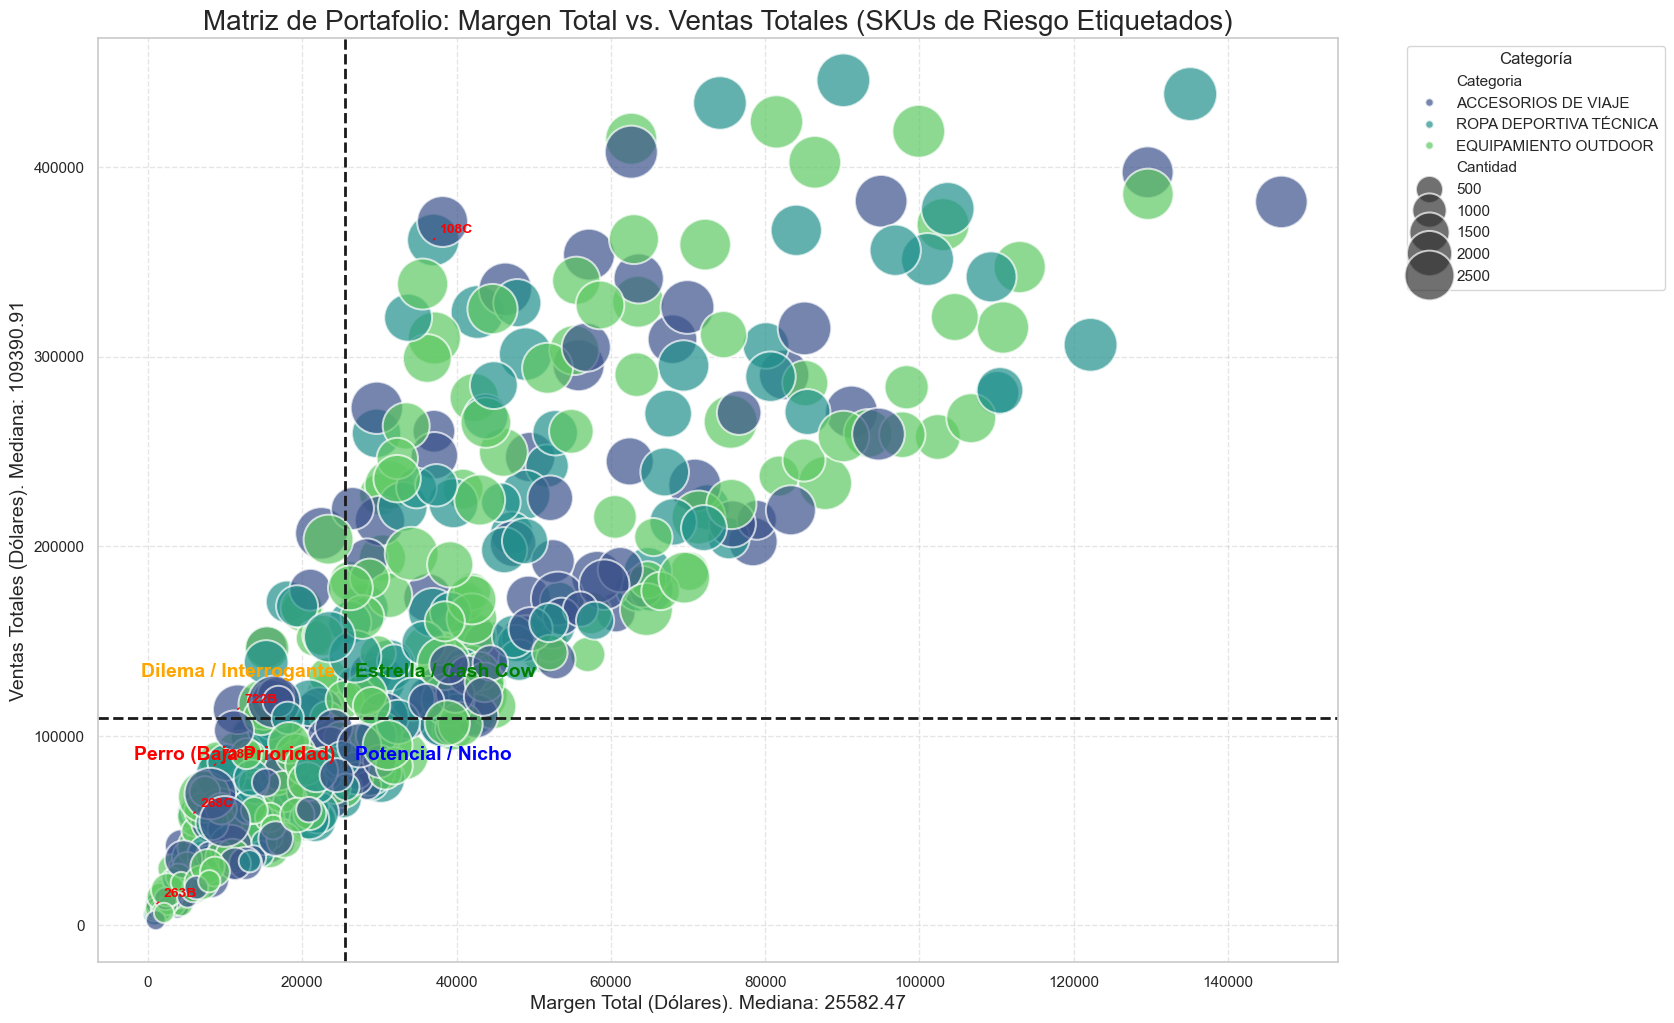

In [10]:
# 1. Calcular puntos de corte (Medianas)
mediana_dolares = df_alto_volumen['Dolares'].median()
mediana_margen_abs = df_alto_volumen['Margen'].median() 

# --- LÓGICA PARA ETIQUETAR: SE IDENTIFICAN LOS PEORES SKUS ---
# 1. Definir los tóxicos críticos (Margen < 15%)
toxicos_criticos = df_alto_volumen[df_alto_volumen['MargenPorcentual'] < UMBRAL_MARGEN]
# 2. Ordenar por el peor margen y seleccionar el Top 5
top_5_toxicos = toxicos_criticos.sort_values('MargenPorcentual', ascending=True).head(5)
# -------------------------------------------------------------

# 2. Configuración del Gráfico
plt.figure(figsize=(16, 12))

# 3. Crear el Scatter Plot: x=Margen (Dólares), y=Ventas (Dólares)
sns.scatterplot(
    data=df_alto_volumen,
    x='Margen', 
    y='Dolares',
    size='Cantidad',
    hue='Categoria',
    sizes=(200, 1500),
    alpha=0.7,
    palette='viridis'
)

# 4. Líneas de Cuadrantes (Mediana como umbral)
plt.axvline(mediana_margen_abs, color='k', linestyle='--', linewidth=2)
plt.axhline(mediana_dolares, color='k', linestyle='--', linewidth=2)

# 5. ETIQUETADO DE PUNTOS CRÍTICOS 
for index, row in top_5_toxicos.iterrows():
    plt.annotate(
        text=row['SKU'], 
        xy=(row['Margen'], row['Dolares']), 
        xytext=(5, 5), # Pequeño desplazamiento de la etiqueta
        textcoords='offset points',
        fontsize=10, 
        color='red',
        weight='bold',
        arrowprops=dict(arrowstyle="-", connectionstyle="arc3,rad=0.2", color='red')
    )

# 6. Etiquetas de los Cuadrantes
plt.text(mediana_margen_abs * 1.05, mediana_dolares * 1.2, 'Estrella / Cash Cow', 
         fontsize=14, color='green', weight='bold') 
plt.text(mediana_margen_abs * 0.95, mediana_dolares * 1.2, 'Dilema / Interrogante', 
         fontsize=14, color='orange', weight='bold', ha='right') 
plt.text(mediana_margen_abs * 0.95, mediana_dolares * 0.8, 'Perro (Baja Prioridad)', 
         fontsize=14, color='red', weight='bold', ha='right') 
plt.text(mediana_margen_abs * 1.05, mediana_dolares * 0.8, 'Potencial / Nicho', 
         fontsize=14, color='blue', weight='bold') 

plt.title("Matriz de Portafolio: Margen Total vs. Ventas Totales (SKUs de Riesgo Etiquetados)", fontsize=20)
plt.xlabel(f"Margen Total (Dólares). Mediana: {mediana_margen_abs:.2f}", fontsize=14)
plt.ylabel(f"Ventas Totales (Dólares). Mediana: {mediana_dolares:.2f}", fontsize=14)
plt.legend(title='Categoría', bbox_to_anchor=(1.05, 1), loc=2)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

### 4. Segmentación Estratégica y Conclusiones

#### 4.1. 🚨 SKUs Tóxicos Críticos (Alto Riesgo)
Estos productos se encuentran principalmente en el cuadrante de **Dilema/Interrogante** (Alto Volumen, Bajo Margen). Generan alta venta, pero contribuyen poco a la ganancia debido a su baja rentabilidad porcentual.

#### 4.2. ⭐ SKUs Cash Cows (Maximizar Ganancias)
Estos productos se ubican en el cuadrante **Estrella/Cash Cow** (Alto Volumen, Alto Margen). Son los pilares de la rentabilidad y el enfoque de inversión para la expansión.

### 5 Consulta Detallada de SKUs por Cuadrante

Una vez clasificados, podemos auditar los SKUs que representan la mayor oportunidad de crecimiento (Nichos) o el mayor riesgo (Dilemas).

In [11]:
# --- Esta celda debe ir después de la Celda 5 (Gráfico BCG) ---

### 5. Clasificación de SKUs por Cuadrante

# Reutilizamos los puntos de corte calculados en la Celda 5 (Gráfico)
mediana_margen = df_alto_volumen['Margen'].median()
mediana_dolares = df_alto_volumen['Dolares'].median()

# Creamos las sub-DataFrames basadas en los ejes de la matriz de Impacto Absoluto
df_cuadrantes = df_alto_volumen.copy()

# 1. CASH COWS / ESTRELLA: Alto Margen (Absoluto) y Alto Volumen (Ventas)
cash_cows = df_cuadrantes[
    (df_cuadrantes['Margen'] >= mediana_margen) & 
    (df_cuadrantes['Dolares'] >= mediana_dolares)
].sort_values('Margen', ascending=False).reset_index(drop=True)

# 2. DILEMA / INTERROGANTE: Bajo Margen (Absoluto) y Alto Volumen (Ventas)
dilemas = df_cuadrantes[
    (df_cuadrantes['Margen'] < mediana_margen) & 
    (df_cuadrantes['Dolares'] >= mediana_dolares)
].sort_values('Dolares', ascending=False).reset_index(drop=True)

# 3. PERRO: Bajo Margen (Absoluto) y Bajo Volumen (Ventas)
perros = df_cuadrantes[
    (df_cuadrantes['Margen'] < mediana_margen) & 
    (df_cuadrantes['Dolares'] < mediana_dolares)
].sort_values('Dolares', ascending=False).reset_index(drop=True)

# 4. POTENCIAL / NICHO: Alto Margen (Absoluto) y Bajo Volumen (Ventas)
nichos = df_cuadrantes[
    (df_cuadrantes['Margen'] >= mediana_margen) & 
    (df_cuadrantes['Dolares'] < mediana_dolares)
].sort_values('Margen', ascending=False).reset_index(drop=True)

print("✅ DataFrames por cuadrante creados exitosamente. Ahora puedes consultarlos directamente:")
print(f"1. Cash Cows: {cash_cows.shape[0]} SKUs")
print(f"2. Dilemas: {dilemas.shape[0]} SKUs")
print(f"3. Perros: {perros.shape[0]} SKUs")
print(f"4. Nichos: {nichos.shape[0]} SKUs")

✅ DataFrames por cuadrante creados exitosamente. Ahora puedes consultarlos directamente:
1. Cash Cows: 220 SKUs
2. Dilemas: 30 SKUs
3. Perros: 220 SKUs
4. Nichos: 30 SKUs


In [12]:
# Ejemplo: Auditar el Top 5 de SKUs Nicho (Alto margen, pero baja venta)
print("--- Top 5 Oportunidades (Nichos): Alto Margen, Baja Venta ---")
display(nichos.head(5)[['SKU', 'Categoria', 'Dolares', 'Margen', 'MargenPorcentual']])

--- Top 5 Oportunidades (Nichos): Alto Margen, Baja Venta ---


,SKU,Categoria,Dolares,Margen,MargenPorcentual
0,227C,EQUIPAMIENTO OUTDOOR,106060.73,40499.34,38.185047
1,918D,EQUIPAMIENTO OUTDOOR,103248.70,39498.96,38.256133
2,263B,ACCESORIOS DE VIAJE,104019.58,39420.63,37.897317
3,990D,EQUIPAMIENTO OUTDOOR,106793.73,38804.31,36.335757
4,718D,ROPA DEPORTIVA TÉCNICA,106435.15,38150.42,35.843817


In [20]:
display(perros)

,Cantidad,Dolares,Costo,Categoria,SKU,Precio_Venta,Margen,MargenPorcentual
0,992,109348.97,86139.20,EQUIPAMIENTO OUTDOOR,823C,110.23,23209.77,21.225413
1,713,105997.43,90125.62,ROPA DEPORTIVA TÉCNICA,159D,148.66,15871.81,14.973769
2,1133,105914.88,88002.84,EQUIPAMIENTO OUTDOOR,290A,93.48,17912.04,16.911731
3,2069,104461.75,88623.25,ROPA DEPORTIVA TÉCNICA,513B,50.49,15838.50,15.162009
4,1276,104190.69,80095.19,ACCESORIOS DE VIAJE,615D,81.65,24095.50,23.126347
...,...,...,...,...,...,...,...,...
215,106,7364.51,6558.74,EQUIPAMIENTO OUTDOOR,346A,69.48,805.77,10.941257
216,100,7149.20,5395.00,EQUIPAMIENTO OUTDOOR,638C,71.49,1754.20,24.537011
217,122,6606.14,4522.52,EQUIPAMIENTO OUTDOOR,307C,54.15,2083.62,31.540658
218,256,6055.02,5186.96,ROPA DEPORTIVA TÉCNICA,645A,23.65,868.06,14.336204


In [24]:
display(cash_cows)

,Cantidad,Dolares,Costo,Categoria,SKU,Precio_Venta,Margen,MargenPorcentual
0,2814,381675.71,234771.56,ACCESORIOS DE VIAJE,312C,135.63,146904.15,38.489258
1,2987,438558.70,303472.88,ROPA DEPORTIVA TÉCNICA,470B,146.82,135085.82,30.802221
2,2674,385710.26,256098.64,EQUIPAMIENTO OUTDOOR,311C,144.24,129611.62,33.603363
3,2730,397290.30,267718.26,ACCESORIOS DE VIAJE,528D,145.53,129572.04,32.613945
4,2958,306273.93,184096.76,ROPA DEPORTIVA TÉCNICA,882A,103.54,122177.17,39.891469
...,...,...,...,...,...,...,...,...
215,971,127753.84,101008.79,ROPA DEPORTIVA TÉCNICA,472D,131.57,26745.05,20.934831
216,1770,219896.47,193376.50,ACCESORIOS DE VIAJE,356B,124.24,26519.97,12.060207
217,1970,178074.79,151828.06,EQUIPAMIENTO OUTDOOR,373D,90.39,26246.73,14.739161
218,1768,159773.11,133589.90,ROPA DEPORTIVA TÉCNICA,879D,90.37,26183.21,16.387745


In [23]:
display(dilemas)

,Cantidad,Dolares,Costo,Categoria,SKU,Precio_Venta,Margen,MargenPorcentual
0,2808,206833.69,184347.85,ACCESORIOS DE VIAJE,139A,73.66,22485.84,10.871459
1,2509,203544.30,180138.51,EQUIPAMIENTO OUTDOOR,298B,81.13,23405.79,11.499113
2,1669,177050.96,156006.52,ACCESORIOS DE VIAJE,379D,106.08,21044.44,11.886092
3,1721,170701.08,152667.74,ROPA DEPORTIVA TÉCNICA,163B,99.19,18033.34,10.564280
4,1685,168367.84,149035.28,ROPA DEPORTIVA TÉCNICA,895A,99.92,19332.56,11.482335
5,1670,167724.45,147835.73,EQUIPAMIENTO OUTDOOR,745A,100.43,19888.72,11.857973
6,1717,165984.98,145977.10,EQUIPAMIENTO OUTDOOR,909B,96.67,20007.88,12.054030
7,1613,152910.50,130221.24,EQUIPAMIENTO OUTDOOR,433B,94.80,22689.26,14.838262
8,2665,152227.55,128678.16,ROPA DEPORTIVA TÉCNICA,144D,57.12,23549.39,15.469861
9,1155,151473.23,129950.86,EQUIPAMIENTO OUTDOOR,216D,131.15,21522.37,14.208695
